In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

# group memberships
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
print(A_t_medical_groups.sum(axis=0))

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64


In [3]:
age_groups = ['young', 'middle', 'old']
bmi_groups = ['underweight', 'healthyweight', 'overweight', 'obese']
A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison

,young,middle,old,underweight,healthyweight,overweight,obese
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
1333,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1334,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1335,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1336,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh[['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']] = A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
added_indicators = ['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']
np.all(df_medical_mm_oh[added_indicators + ['smoker_yes', 'smoker_no', 'sex_male', 'sex_female']].to_numpy() == A_t_medical_groups.to_numpy()[:, :11]) # checks that A_t information is all included in the dataframe! no loss of group info to baseline so a fair comparison

True

In [12]:
from bilevel.Groupwise_sortedseedruns import BuildGroupwise_noniid
ds_ob = BuildGroupwise_noniid(df_medical_mm_oh, 'charges', 'age', A_t_medical_groups, ascending=True)
ds_ob.build_all_seeds()
ds_ob.build_df_res()
ds_ob.build_regret_curve()

100%|██████████| 1338/1338 [00:00<00:00, 7105.83it/s]


young 574


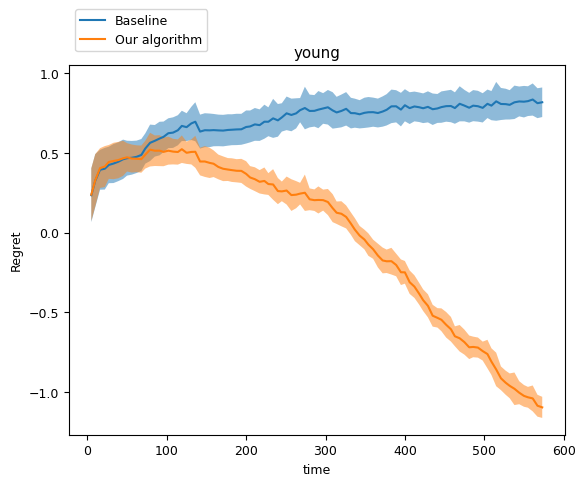

middle 408


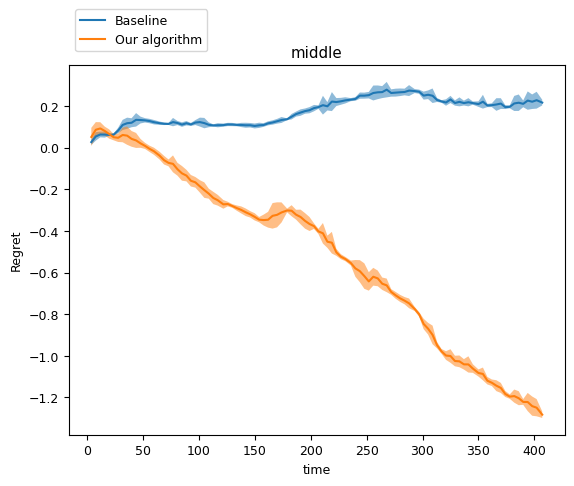

old 356


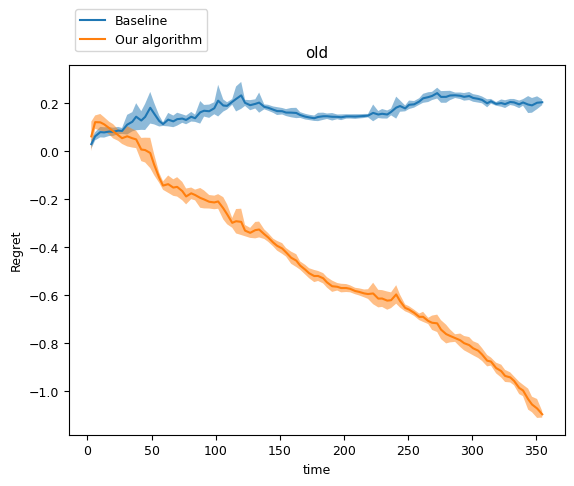

underweight 20


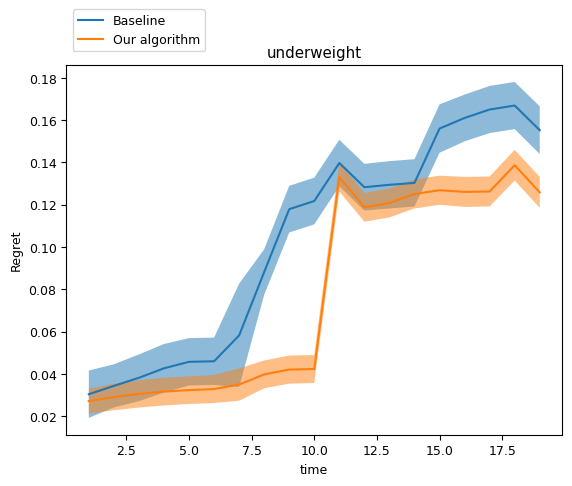

healthyweight 225


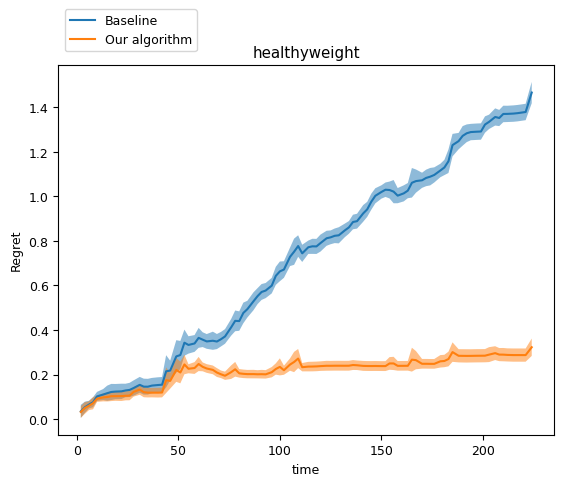

overweight 386


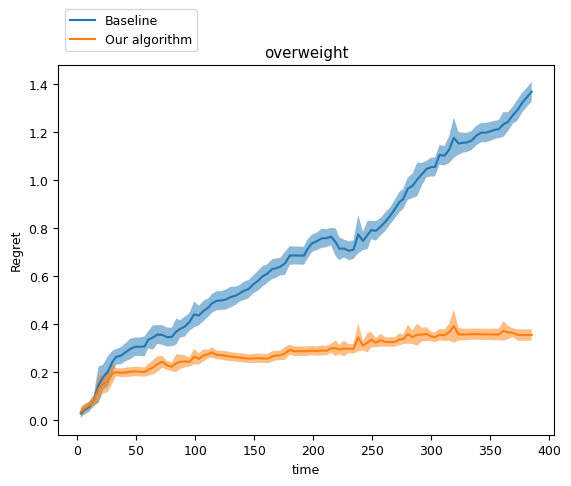

obese 707


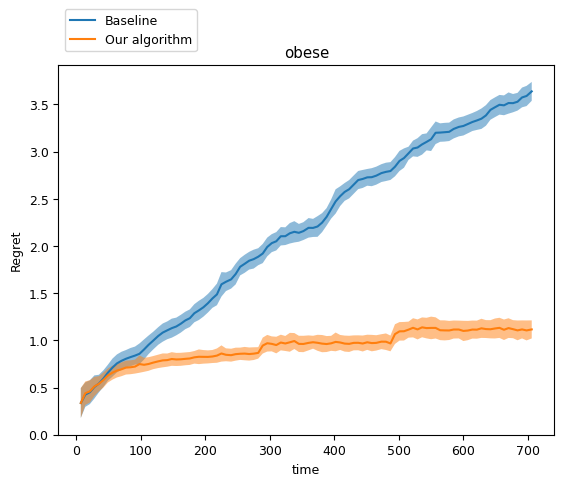

smoker 274


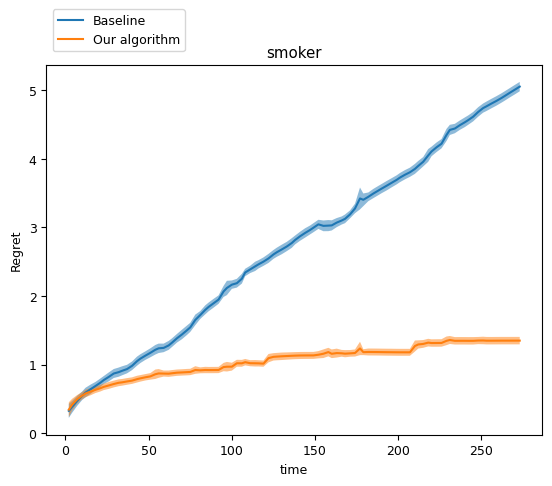

non-smoker 1064


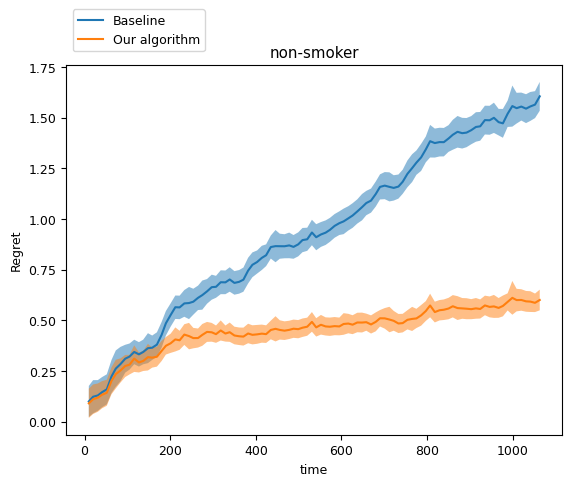

male 676


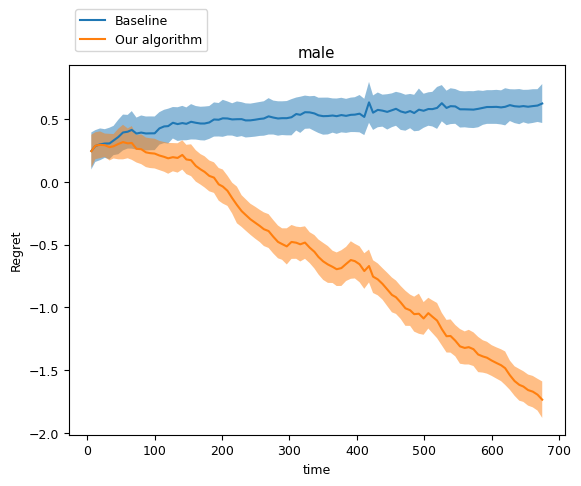

female 662


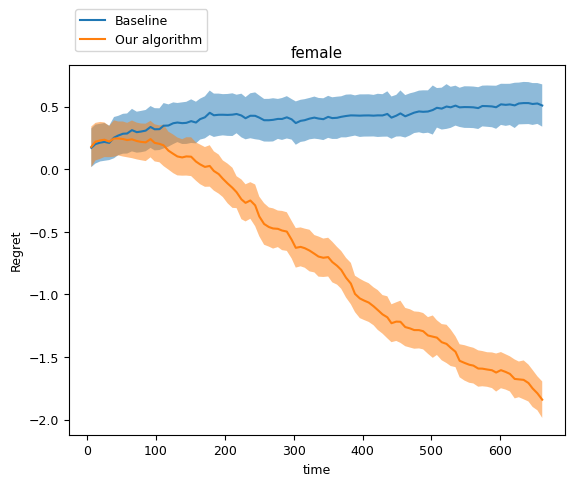

always_on 1338


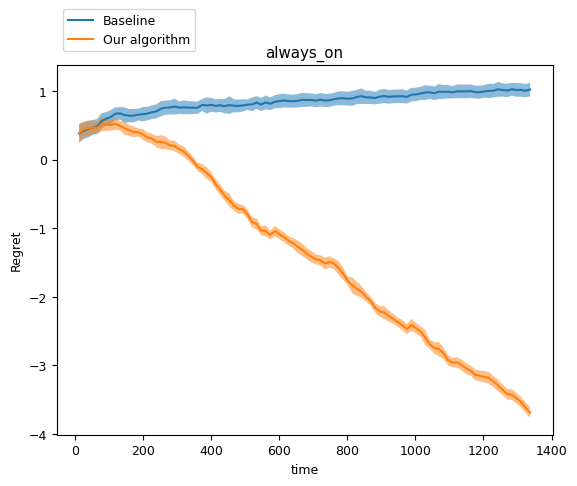

In [13]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std # ascending age
plot_regret_curve_with_std(ds_ob, 'medical_costs_plots_ascendingage')

In [10]:
group_to_ind = {}
for ind, val in enumerate(ds_ob.group_names):
    group_to_ind[ind] = val
print(group_to_ind)

age_indices = [0, 1, 2] # young, middle, old
bmi_indices = [3, 4, 5 ,6] # under, healthy, over, obse
smoker_indices = [7, 8] # smoker, non-smoker
sex_indices = [9, 10] # male, female
always_on = [11] # always on

import matplotlib
matplotlib.rcParams.update({'font.size': 9})
def plot_regret_curve_with_std(gwise_obj, gindices: list, title:str):
    ax = plt.gca()
    for g_ind in gindices:
        gwise_obj.regret_Anh_groupwise_array[g_ind] = np.array(gwise_obj.regret_Anh_groupwise_array[g_ind]) # all 10 values in the row have same dim, so can make np array
        gwise_obj.regret_Base_groupwise_array[g_ind] = np.array(gwise_obj.regret_Base_groupwise_array[g_ind])
        gname = gwise_obj.group_names[g_ind]
        print(gname, gwise_obj.group_sizes[g_ind])
        mean_reg_Anh, sd_reg_Anh = gwise_obj.regret_Anh_groupwise_array[g_ind].mean(axis = 0), gwise_obj.regret_Anh_groupwise_array[g_ind].std(axis = 0)
        mean_reg_Base, sd_reg_Base = gwise_obj.regret_Base_groupwise_array[g_ind].mean(axis = 0), gwise_obj.regret_Base_groupwise_array[g_ind].std(axis = 0)
        # plt.plot(self.pos[g_ind], self.regret_Anh_groupwise_array[g_ind][0], label = 'mean(ada - besthind_ls)')
        Tg = gwise_obj.group_sizes[g_ind]
        color=next(ax._get_lines.prop_cycler)['color']
        plt.plot(gwise_obj.pos[g_ind] / Tg, mean_reg_Base , label = (gname + ' (Baseline)').title(), color = color, marker = '*', markevery = 5)
        # plt.fill_between(gwise_obj.pos[g_ind], mean_reg_Base - sd_reg_Base, mean_reg_Base + sd_reg_Base, alpha = 0.5)
        plt.plot(gwise_obj.pos[g_ind] / Tg, mean_reg_Anh , label = (gname + ' (Our algorithm)').title(),  color = color)
        # plt.fill_between(gwise_obj.pos[g_ind], mean_reg_Anh - sd_reg_Anh, mean_reg_Anh + sd_reg_Anh, alpha = 0.5)
        # plt.legend(bbox_to_anchor=(0, 1.02, 0.8, 0.2), loc ='lower left', mode='expand', ncol = 2)
        # plt.legend(bbox_to_anchor=(0, 1.02, 1.0, 0.2), loc ='lower left')
        # plt.title(gname)
        # plt.savefig(dir_name + '/regret_'+ gname +'.pdf')
    plt.legend()
    plt.xlabel('Time / length of subsequence')
    plt.ylabel('Cumulative regret')
    plt.title(title)
    plt.savefig(title +'.pdf')
    plt.show()

{0: 'young', 1: 'middle', 2: 'old', 3: 'underweight', 4: 'healthyweight', 5: 'overweight', 6: 'obese', 7: 'smoker', 8: 'non-smoker', 9: 'male', 10: 'female', 11: 'always_on'}


young 574
middle 408
old 356
male 676
female 662


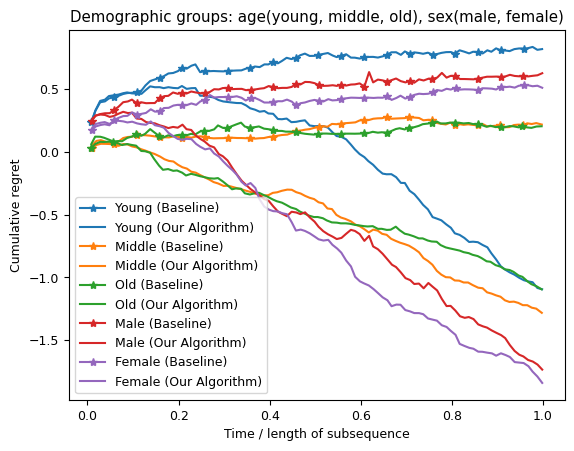

In [11]:
plot_regret_curve_with_std(ds_ob, age_indices+sex_indices, "Demographic groups: age(young, middle, old), sex(male, female)")

In [ ]:
plot_regret_curve_with_std(ds_ob, age_indices+sex_indices, "Demographic groups: age(young, middle, old), sex(male, female)")